In [110]:
import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [111]:
class UnetSkipConnectionBlock(nn.Module):
    def __init__(self, outer_nc, inner_nc, input_nc=None, submodule=None, outermost=False, innermost=False, use_dropout=False):
        super(UnetSkipConnectionBlock, self).__init__()
        self.outermost = outermost

        if input_nc is None:
            input_nc = outer_nc

        downconv = nn.Conv2d(input_nc, inner_nc, kernel_size=4, stride=2, padding=1, bias=False)
        # downrelu = nn.LeakyReLU(0.2, inplace=True)
        downrelu = nn.LeakyReLU(0.1, inplace=True)
        uprelu = nn.ReLU(inplace=True)
        upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc, kernel_size=4, stride=2, padding=1, bias=False)

        if outermost:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc, kernel_size=4, stride=2, padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.ReLU()]  # Output activation
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(inner_nc, outer_nc, kernel_size=4, stride=2, padding=1, bias=False)
            model = [downrelu, downconv, nn.Identity(), uprelu, upconv, nn.Identity()]
        else:
            model = [downrelu, downconv, nn.Identity(), submodule, uprelu, upconv, nn.Identity()]
            if use_dropout:
                model += [nn.Identity()]  # Replace dropout with Identity

        self.model = nn.Sequential(*model)

    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:
            return torch.cat([x, self.model(x)], 1)


class UnetGenerator(nn.Module):
    def __init__(self, input_nc, output_nc, num_downs):
        super(UnetGenerator, self).__init__()

        # Construct U-Net structure
        unet_block = UnetSkipConnectionBlock(512, 512, innermost=True)
        for _ in range(num_downs - 5):  # 5 includes innermost + 4 outer layers
            unet_block = UnetSkipConnectionBlock(512, 512, submodule=unet_block, use_dropout=True)
        unet_block = UnetSkipConnectionBlock(256, 512, submodule=unet_block)
        unet_block = UnetSkipConnectionBlock(128, 256, submodule=unet_block)
        unet_block = UnetSkipConnectionBlock(64, 128, submodule=unet_block)
        self.model = UnetSkipConnectionBlock(output_nc, 64, input_nc=input_nc, submodule=unet_block, outermost=True)

    def forward(self, x):
        return self.model(x)


In [112]:
model = UnetGenerator(input_nc=3, output_nc=3, num_downs=8)

In [113]:
# check model structure
print(model)

UnetGenerator(
  (model): UnetSkipConnectionBlock(
    (model): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): UnetSkipConnectionBlock(
        (model): Sequential(
          (0): LeakyReLU(negative_slope=0.1, inplace=True)
          (1): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
          (2): Identity()
          (3): UnetSkipConnectionBlock(
            (model): Sequential(
              (0): LeakyReLU(negative_slope=0.1, inplace=True)
              (1): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
              (2): Identity()
              (3): UnetSkipConnectionBlock(
                (model): Sequential(
                  (0): LeakyReLU(negative_slope=0.1, inplace=True)
                  (1): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
                  (2): Identity()
                  (3): UnetSkipConnectionB

In [114]:
# load model pth
def load_model(model, path):
    model.load_state_dict(torch.load(path))
    print(f"Model loaded from {path}")

model_path = '1_model/training_pix2pix_denoiser_denoiser.pth'

load_model(model, model_path)

Model loaded from 1_model/training_pix2pix_denoiser_denoiser.pth


In [115]:
resolution_def = 'facades'
# HD 1280x720
# FullHD 1920x1080
# 2k 2048x1080
# 2kdci 2560x1440
# 4k 3840x2160
# 4kdci 4096x2160
# test 1024x1024
# NCHW
if resolution_def == 'FullHD':
    dummy_input = torch.randn(1, 3, 1080, 1920, dtype=torch.float32) # NCHW
elif resolution_def == '2K':
    dummy_input = torch.randn(1, 3, 1080, 2048, dtype=torch.float32)
elif resolution_def == '2KDCI':
    dummy_input = torch.randn(1, 3, 1440, 2560, dtype=torch.float32)
elif resolution_def == '4K':
    dummy_input = torch.randn(1, 3, 2160, 3840, dtype=torch.float32)
elif resolution_def == '4KDCI':
    dummy_input = torch.randn(1, 3, 2160, 4096, dtype=torch.float32)
elif resolution_def == 'facades':
    dummy_input = torch.randn(1, 3, 256, 256, dtype=torch.float32)
else:
    raise ValueError("Unsupported resolution definition. Please choose from 'FullHD', '2K', '2KDCI', '4K', '4KDCI', or 'test'.")



In [116]:
model_name = 'training_pix2pix_denoiser_denoiser'

# Save the model to 1_model/
torch.save(model.state_dict(), '1_model/'+ model_name +'_f32.pth', _use_new_zipfile_serialization=False )

# Save the onnx model as well
# dummy_input = torch.randn(1, 3, 1024, 1024, dtype=torch.float32)
torch.onnx.export(model, dummy_input, '1_model/'+ model_name + '_'+ resolution_def +'_f32.onnx', 
                  input_names=['input'], output_names=['output'], 
                  dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}})
# Save the model to 1_model/ in ONNX format
print("Model saved ")

Model saved 


In [117]:
import kagglehub

path = kagglehub.dataset_download("balraj98/facades-dataset")
print("Path to dataset files:", path)


Path to dataset files: /home/changhong/.cache/kagglehub/datasets/balraj98/facades-dataset/versions/1


In [118]:
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class FacadesDataset(Dataset):
    def __init__(self, root_dir, transform=None, mode='train'):
        self.root_dir = root_dir
        self.transform = transform
        self.mode = mode
        self.image_dir = os.path.join(root_dir, f'{mode}A')  # trainA or testA
        self.image_files = sorted([f for f in os.listdir(self.image_dir) if f.endswith('.jpg')])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(img_path).convert('RGB')  # RGB

        if self.transform:
            image = self.transform(image)

        return image 

# preprosessing
transform = transforms.Compose([
    transforms.Resize((256, 256)),      
    transforms.ToTensor(),               
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  #  [-1, 1]
])

# load dataset
train_dataset = FacadesDataset(root_dir='0_data/facades', transform=transform, mode='train')
test_dataset = FacadesDataset(root_dir='0_data/facades', transform=transform, mode='test')

# create DataLoader
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# check dataset size
print(f"Train samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

# check one batch of images
images = next(iter(train_loader))
print(f"image shape: {images.shape}")  # should be [batch_size, 3, 256, 256]

Train samples: 400
Test samples: 106
image shape: torch.Size([64, 3, 256, 256])


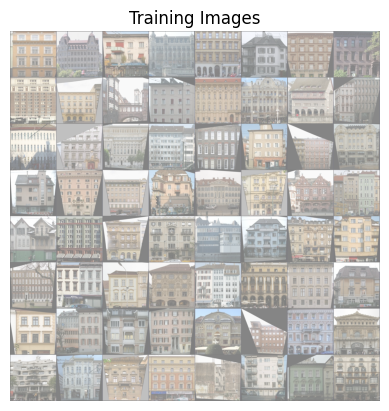

In [119]:
import matplotlib.pyplot as plt
import torchvision
import numpy as np

def imshow(img, title=None):
    img = img * 0.5 + 0.5  # 反归一化
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title is not None:
        plt.title(title)
    plt.axis('off')
    plt.show()

# 显示一个 batch 的训练图像
images = next(iter(train_loader))
if isinstance(images, tuple):  # 如果是图像对
    imgA, imgB = images
    imshow(torchvision.utils.make_grid(imgA), title='Input Images')
    imshow(torchvision.utils.make_grid(imgB), title='Target Images')
else:  # 如果是单张图像
    imshow(torchvision.utils.make_grid(images), title='Training Images')


In [120]:
BATCH_SIZE = 64
EPOCHS = 20
NOISE_FACTOR = 0.2
LEARNING_RATE = 0.001

model = model.float()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

def add_noise(images, noise_factor=NOISE_FACTOR):
    noise = noise_factor * torch.randn_like(images)  
    noisy_images = images + noise
    noisy_images = torch.clamp(noisy_images, 0., 1.)  
    return noisy_images

def train(model, trainloader, device):
    model.train()
    model.to(device)
    train_loss = 0
    for images, _ in trainloader:
        images = images.to(device)
        noisy_images = add_noise(images).to(device)
        
        optimizer.zero_grad()
        outputs = model(noisy_images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    return train_loss / len(trainloader)

def test(model, testloader, device):
    model.eval()
    model.to(device)
    test_loss = 0
    with torch.no_grad():
        for images, _ in testloader:
            images = images.to(device)
            noisy_images = add_noise(images).to(device)
            outputs = model(noisy_images)
            loss = criterion(outputs, images)
            test_loss += loss.item()
    return test_loss / len(testloader)

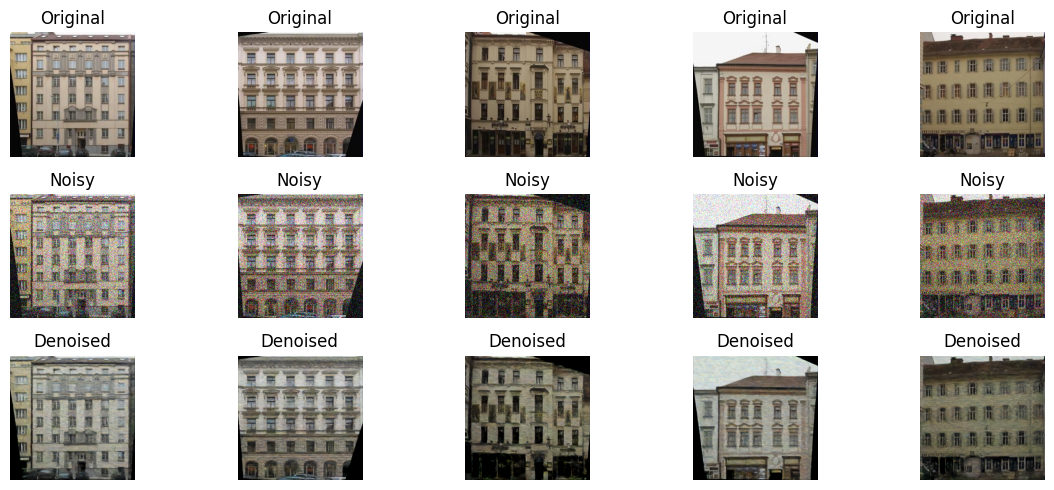

In [121]:
import matplotlib.pyplot as plt
import torch

# model back to CPU for visualization
model = model.to('cpu')

# Assuming dataiter, testloader, add_noise, and model are defined
dataiter = iter(test_loader)
images = next(dataiter)
noisy_images = add_noise(images)
outputs = model(noisy_images)


number_of_images = 5  # Number of images to visualize

# Plot original, noisy, and denoised images
fig, axes = plt.subplots(3, number_of_images, figsize=(12, number_of_images))
for i in range(number_of_images):
    # Transpose images from (3, 32, 32) to (32, 32, 3) for RGB
    # Original images
    orig_img = images[i].permute(1, 2, 0).numpy()  # Change shape to (32, 32, 3)
    # map the values to [0, 1] range for visualization
    orig_img = (orig_img - orig_img.min()) / (orig_img.max() - orig_img.min())
    # print the shape and type and value range of the original image
    #print(f"Original image shape: {orig_img.shape}, type: {orig_img.dtype}, value range: {orig_img.min()} - {orig_img.max()}")
    axes[0, i].imshow(orig_img)
    axes[0, i].set_title("Original")
    axes[0, i].axis('off')
    # save the original image to clean folder
    
    # Noisy images
    noisy_img = noisy_images[i].permute(1, 2, 0).numpy()  # Change shape to (32, 32, 3)
    # map the values to [0, 1] range for visualization
    noisy_img = (noisy_img - noisy_img.min()) / (noisy_img.max() - noisy_img.min())
    # print the shape and type of the noisy image
    #print(f"Noisy image shape: {noisy_img.shape}, type: {noisy_img.dtype}, value range: {noisy_img.min()} - {noisy_img.max()}")
    #noisy_img = (noisy_img - noisy_img.min()) / (noisy_img.max() - noisy_img.min())  # Normalize for visualization
    axes[1, i].imshow(noisy_img)
    axes[1, i].set_title("Noisy")
    axes[1, i].axis('off')
    
    # Denoised images
    denoised_img = outputs[i].permute(1, 2, 0).detach().numpy()  # Change shape to (32, 32, 3)
    # map the values to [0, 1] range for visualization
    denoised_img = (denoised_img - denoised_img.min()) / (denoised_img.max() - denoised_img.min())
    # print the shape and type of the denoised image
    #print(f"Denoised image shape: {denoised_img.shape}, type: {denoised_img.dtype}, value range: {denoised_img.min()} - {denoised_img.max()}")
    axes[2, i].imshow(denoised_img)
    axes[2, i].set_title("Denoised")
    axes[2, i].axis('off')

    # save all images to their corresponding folders under 3_output
    # if folder does not exist, create it
    import os
    output_dir = '3_output/facades_test'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    clean_dir = os.path.join(output_dir, 'clean')
    noisy_dir = os.path.join(output_dir, 'noisy')
    denoised_dir = os.path.join(output_dir, 'denoised')
    if not os.path.exists(clean_dir):
        os.makedirs(clean_dir)
    if not os.path.exists(noisy_dir):
        os.makedirs(noisy_dir)
    if not os.path.exists(denoised_dir):
        os.makedirs(denoised_dir)
    # save images
    from torchvision.utils import save_image
    save_image(images[i], os.path.join(clean_dir, f'clean_{i}.png'))
    save_image(noisy_images[i], os.path.join(noisy_dir, f'noisy_{i}.png'))
    save_image(outputs[i], os.path.join(denoised_dir, f'denoised_{i}.png')) 
 

plt.tight_layout()
plt.show()